<a href="https://colab.research.google.com/github/EduardoAve/Data-science-portfolio/blob/main/imdb-sentiment-analysis/nlp_sentiment_analysis_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# ==============================================================================
# 1. LIBRARY IMPORTS AND SETUP (NLTK Removed)
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # Regular expressions for text cleaning
# NLTK imports removed

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer # Keep vectorizer
from sklearn.linear_model import LogisticRegression # Simple baseline model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline # Keep pipeline

import warnings
import os
import time # To time processes

# Basic configurations
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 150) # Show more text in columns
warnings.filterwarnings('ignore')

# --- NLTK Downloads Removed ---

print("Libraries imported (NLTK removed).")


Libraries imported (NLTK removed).


In [15]:

# ==============================================================================
# 2. DATA LOADING AND INITIAL INSPECTION (Manual Upload)
# ==============================================================================
# --- Instructions ---
# Assumes you have uploaded the 'IMDB Dataset.csv' file
# using the "Files" panel on the left in Colab.

# --- Verify file presence with !ls before trying Python ---
print("\n--- Listing files in /content/ directory (before loading): ---")
!ls -lh /content/
print("-------------------------------------------------------------")
# --- END Added Check ---

try:
    # Define the expected filename
    file_name = 'IMDB Dataset.csv'
    data_loaded = False
    print(f"\nAttempting to load '{file_name}' using Python os.path.exists...") # Added newline for spacing

    # Verify if the file exists in /content/ using Python
    if os.path.exists(file_name):
        print(f"Python os.path.exists confirms '{file_name}' is present.")
        # Load the dataset using engine='python' and specifying escapechar
        df_nlp = pd.read_csv(file_name, engine='python', escapechar='\\') # Using escapechar fix
        print(f"\nFile '{file_name}' found and DataFrame loaded successfully (using engine='python', escapechar='\\').")

        # --- Initial Inspection ---
        print("\n--- Basic DataFrame Info ---")
        df_nlp.info()

        print("\n--- DataFrame Shape (Rows, Columns) ---")
        print(df_nlp.shape)

        print("\n--- Column Names ---")
        actual_columns = df_nlp.columns.tolist() # Store actual names
        print(actual_columns)

        print("\n--- First 5 Rows ---")
        print(df_nlp.head())

        # Check for null values specifically in expected columns
        review_col = 'review' # Expected name
        sentiment_col = 'sentiment' # Expected name

        # Verify if expected columns exist
        if review_col not in actual_columns:
             print(f"\nWarning: Column '{review_col}' not found. Please verify actual names.")
             if actual_columns: review_col = actual_columns[0]

        if sentiment_col not in actual_columns:
             print(f"\nWarning: Column '{sentiment_col}' not found. Please verify actual names.")
             if len(actual_columns) > 1: sentiment_col = actual_columns[1]


        # Proceed with inspection if columns (or substitutes) seem to exist
        if review_col in df_nlp.columns:
             print(f"\n--- Null Values in '{review_col}' ---")
             print(df_nlp[review_col].isnull().sum())
        else:
             print(f"\nCould not identify the review column.")

        if sentiment_col in df_nlp.columns:
             print(f"\n--- Null Values in '{sentiment_col}' ---")
             print(df_nlp[sentiment_col].isnull().sum())
             print(f"\n--- Distribution of '{sentiment_col}' ---")
             try:
                 print(df_nlp[sentiment_col].value_counts())
                 print(f"\nUnique values in '{sentiment_col}': {df_nlp[sentiment_col].unique()}")
             except Exception as e_vc:
                 print(f"Could not get value_counts for '{sentiment_col}': {e_vc}")
        else:
             print(f"\nCould not identify the sentiment column.")


        data_loaded = True
        # --- End Initial Inspection ---

    else:
        # This block runs if os.path.exists(file_name) is False
        print(f"\nError: Python os.path.exists could not find '{file_name}' in /content/.")
        print("Please ensure the file was uploaded correctly using the 'Files' panel on the left with the EXACT name.")
        data_loaded = False

except Exception as e:
    if "tokenizing data" in str(e) or "unexpected end of data" in str(e) or "Error tokenizing data" in str(e):
         print(f"\nError reading CSV (Parsing/Tokenizing Error): {e}")
    else:
         print(f"\nAn unexpected error occurred while loading or inspecting the CSV: {e}")
         import traceback
         traceback.print_exc()
    data_loaded = False

if data_loaded:
    print("\nInitial data inspection completed.")
else:
    print("\nCould not complete initial data inspection.")




--- Listing files in /content/ directory (before loading): ---
total 64M
-rw-r--r-- 1 root root  64M Apr 20 01:53 'IMDB Dataset.csv'
drwxr-xr-x 1 root root 4.0K Apr 17 13:36  sample_data
-------------------------------------------------------------

Attempting to load 'IMDB Dataset.csv' using Python os.path.exists...
Python os.path.exists confirms 'IMDB Dataset.csv' is present.

File 'IMDB Dataset.csv' found and DataFrame loaded successfully (using engine='python', escapechar='\').

--- Basic DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB

--- DataFrame Shape (Rows, Columns) ---
(50000, 2)

--- Column Names ---
['review', 'sentiment']

--- First 5 Rows ---
                                                        

In [16]:

# ==============================================================================
# 3. SIMPLIFIED TEXT PREPROCESSING (Basic Cleaning Only)
# ==============================================================================
# Apply only basic cleaning steps. NLTK steps (Tokenize, Stopwords, Lemma) removed.

if data_loaded and 'review_col' in locals() and 'sentiment_col' in locals():
    print(f"\n--- Starting Simplified Text Preprocessing for column '{review_col}' ---")

    # Verify that the columns exist BEFORE trying to use them
    if review_col in df_nlp.columns and sentiment_col in df_nlp.columns:

        start_time = time.time()

        # --- STEP 3.1: Basic Cleaning ---
        print("Applying basic cleaning (lowercase, HTML, non-letters)...")
        # Ensure string type before operations
        df_nlp['processed_text'] = df_nlp[review_col].astype(str).str.lower()
        # Remove HTML
        df_nlp['processed_text'] = df_nlp['processed_text'].str.replace(r'<.*?>', '', regex=True)
        # Remove non-alphabetic characters (keeping spaces)
        df_nlp['processed_text'] = df_nlp['processed_text'].str.replace(r'[^a-z\s]', '', regex=True)
        # Remove extra whitespace
        df_nlp['processed_text'] = df_nlp['processed_text'].str.strip()
        df_nlp['processed_text'] = df_nlp['processed_text'].str.replace(r'\s+', ' ', regex=True)
        # Fill any NaNs that might have been introduced
        df_nlp['processed_text'].fillna('', inplace=True)
        print("Basic cleaning completed.")

        # --- NLTK Steps Removed ---
        # print("Tokenizing text...")
        # print("Removing stopwords...")
        # print("Lemmatizing tokens...")
        # print("Joining lemmatized tokens into final text...")
        # --- End Removed Steps ---

        end_time = time.time()
        print(f"\nSimplified text preprocessing completed in {end_time - start_time:.2f} seconds.")

        print("\n--- Example of Processed Text (First Row) ---")
        if 0 in df_nlp.index and 'processed_text' in df_nlp.columns:
             print("Original:", df_nlp.loc[0, review_col])
             print("Processed (Cleaned Only):", df_nlp.loc[0, 'processed_text'])
        else:
             print("Cannot show example (index 0 or 'processed_text' column does not exist).")

        preprocessing_text_done = True

    else:
        print(f"Error: Columns '{review_col}' or '{sentiment_col}' not found to start preprocessing.")
        preprocessing_text_done = False
else:
    print("\nSkipping Text Preprocessing: Data not loaded.")
    preprocessing_text_done = False



--- Starting Simplified Text Preprocessing for column 'review' ---
Applying basic cleaning (lowercase, HTML, non-letters)...
Basic cleaning completed.

Simplified text preprocessing completed in 5.71 seconds.

--- Example of Processed Text (First Row) ---
Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high 


--- Starting Basic EDA ---


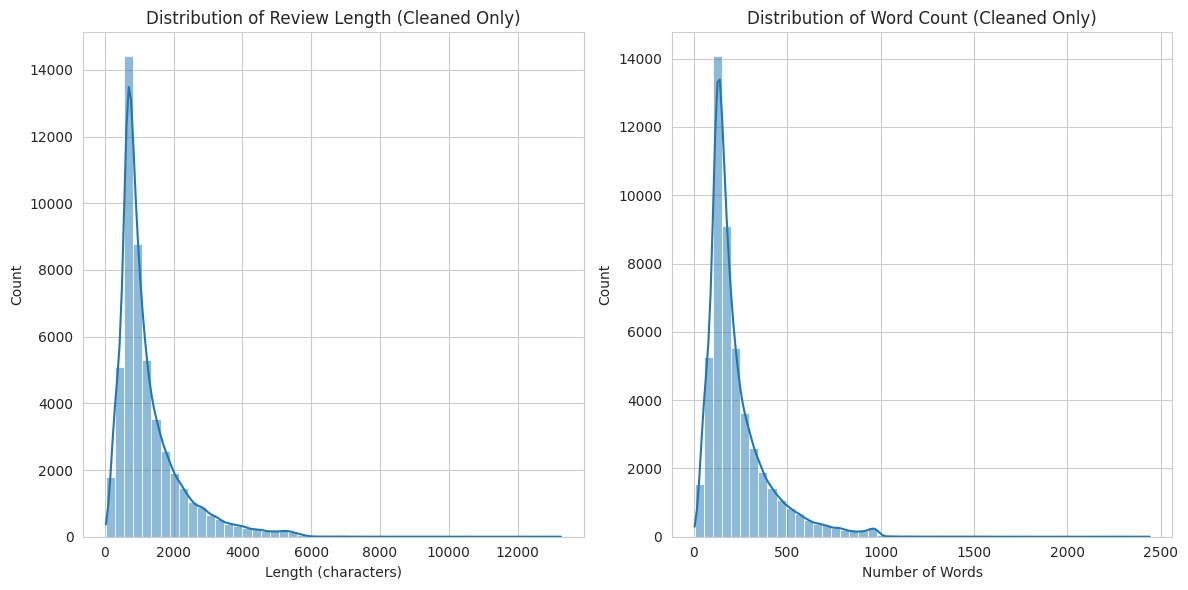

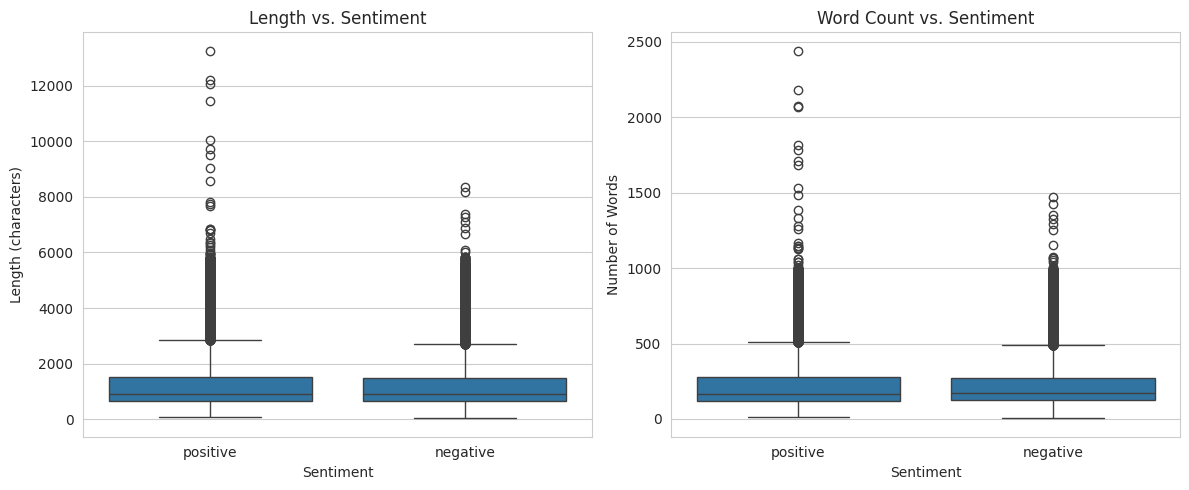

Basic EDA completed.


In [17]:

# ==============================================================================
# 4. BASIC EDA (Exploratory Data Analysis)
# ==============================================================================
# Uses the simplified 'processed_text' column
if preprocessing_text_done and sentiment_col in df_nlp.columns and 'processed_text' in df_nlp.columns:
    print("\n--- Starting Basic EDA ---")

    # Analyze review length (using simplified processed text)
    if 'processed_text' in df_nlp.columns and not df_nlp['processed_text'].empty:
        df_nlp['review_length'] = df_nlp['processed_text'].astype(str).apply(len)
        df_nlp['word_count'] = df_nlp['processed_text'].astype(str).apply(lambda x: len(x.split())) # Simple word count

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(df_nlp['review_length'], bins=50, kde=True)
        plt.title('Distribution of Review Length (Cleaned Only)')
        plt.xlabel('Length (characters)')

        plt.subplot(1, 2, 2)
        sns.histplot(df_nlp['word_count'], bins=50, kde=True)
        plt.title('Distribution of Word Count (Cleaned Only)')
        plt.xlabel('Number of Words')

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        if sentiment_col in df_nlp.columns:
             sns.boxplot(x=df_nlp[sentiment_col], y=df_nlp['review_length'])
             plt.title('Length vs. Sentiment')
             plt.xlabel('Sentiment')
             plt.ylabel('Length (characters)')
        else:
             plt.title('Length Boxplot unavailable')

        plt.subplot(1, 2, 2)
        if sentiment_col in df_nlp.columns:
             sns.boxplot(x=df_nlp[sentiment_col], y=df_nlp['word_count'])
             plt.title('Word Count vs. Sentiment')
             plt.xlabel('Sentiment')
             plt.ylabel('Number of Words')
        else:
             plt.title('Word Count Boxplot unavailable')

        plt.tight_layout()
        plt.show()
    else:
        print("Could not analyze length/count.")

    print("Basic EDA completed.")
    eda_done = True

else:
    print("\nSkipping EDA: Text preprocessing not completed or required columns missing.")
    eda_done = False



In [10]:

# ==============================================================================
# 5. PREPARATION FOR MODELING (Split and Vectorization - Implemented)
# ==============================================================================
if eda_done and 'processed_text' in df_nlp.columns and sentiment_col in df_nlp.columns:
    print("\n--- Starting Preparation for Modeling ---")

    # --- STEP 5.1: Train/Test Split ---
    try:
        X_nlp = df_nlp['processed_text'] # Features are the simplified processed reviews
        y_nlp = df_nlp[sentiment_col]    # Target is the sentiment

        # Convert sentiment labels to numeric
        y_nlp_numeric = None
        if y_nlp.dtype == 'object':
             sentiment_map = {'positive': 1, 'negative': 0}
             print(f"Mapping sentiment labels: {sentiment_map}")
             y_nlp_numeric = y_nlp.map(sentiment_map)
             if y_nlp_numeric.isnull().any():
                  print(f"Warning: Null values found after mapping sentiment. Dropping rows.")
                  original_len = len(df_nlp)
                  df_nlp_temp = df_nlp.assign(sentiment_numeric=y_nlp_numeric)
                  df_nlp_temp.dropna(subset=['sentiment_numeric'], inplace=True)
                  X_nlp = df_nlp_temp['processed_text']
                  y_nlp_numeric = df_nlp_temp['sentiment_numeric'].astype(int)
                  print(f"Dropped {original_len - len(df_nlp_temp)} rows.")
             else:
                  y_nlp_numeric = y_nlp_numeric.astype(int)
        elif pd.api.types.is_numeric_dtype(y_nlp):
             y_nlp_numeric = y_nlp.astype(int)
             print("Sentiment labels are already numeric.")
        else:
             raise TypeError("Unexpected data type for sentiment column.")

        if y_nlp_numeric is not None and not y_nlp_numeric.empty:
            X_train_nlp, X_test_nlp, y_train_nlp, y_test_nlp = train_test_split(
                X_nlp, y_nlp_numeric, test_size=0.25, random_state=42, stratify=y_nlp_numeric
            )
            print(f"Data split into Train ({X_train_nlp.shape[0]} samples) and Test ({X_test_nlp.shape[0]} samples).")
            split_nlp_done = True
        else:
            print("Error: Could not obtain valid numeric labels for y_nlp. Cannot split.")
            split_nlp_done = False

    except Exception as e:
        print(f"Error during train/test split for NLP: {e}")
        import traceback
        traceback.print_exc()
        split_nlp_done = False

    # --- STEP 5.2: Text Vectorization (TF-IDF) ---
    if split_nlp_done:
        print("\nVectorizing text using TF-IDF...")
        # Using stop_words='english' here is important now NLTK removal is gone
        tfidf_vectorizer = TfidfVectorizer(
            max_features=7500,
            ngram_range=(1, 2),
            stop_words='english' # Use built-in stop words
            )
        try:
             print("Fitting TF-IDF vectorizer on training data...")
             start_time = time.time()
             X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_nlp)
             end_time = time.time()
             print(f"TF-IDF fitting completed in {end_time - start_time:.2f} seconds.")

             print("Transforming test data...")
             X_test_tfidf = tfidf_vectorizer.transform(X_test_nlp)

             print(f"Text vectorized. Shape of X_train_tfidf: {X_train_tfidf.shape}")
             print(f"Text vectorized. Shape of X_test_tfidf: {X_test_tfidf.shape}")
             vectorization_done = True
        except Exception as e:
             print(f"Error during TF-IDF vectorization: {e}")
             vectorization_done = False
    else:
        print("\nSkipping Vectorization: Train/Test split failed.")
        vectorization_done = False

else:
    print("\nSkipping Preparation for Modeling NLP: Previous steps not completed.")
    split_nlp_done = False
    vectorization_done = False




--- Starting Preparation for Modeling ---
Mapping sentiment labels: {'positive': 1, 'negative': 0}
Data split into Train (37500 samples) and Test (12500 samples).

Vectorizing text using TF-IDF...
Fitting TF-IDF vectorizer on training data...
TF-IDF fitting completed in 26.63 seconds.
Transforming test data...
Text vectorized. Shape of X_train_tfidf: (37500, 7500)
Text vectorized. Shape of X_test_tfidf: (12500, 7500)


In [11]:

# ==============================================================================
# 6. MODELING (Baseline Implemented)
# ==============================================================================
if vectorization_done:
    print("\n--- Starting Modeling (Logistic Regression Baseline) ---")

    logreg_nlp = LogisticRegression(random_state=42, max_iter=1000, C=1.0)

    try:
        print("Training Logistic Regression model...")
        start_time = time.time()
        logreg_nlp.fit(X_train_tfidf, y_train_nlp)
        end_time = time.time()
        print(f"Logistic Regression model trained in {end_time - start_time:.2f} seconds.")
        model_nlp_trained = True
        trained_nlp_models = {'Logistic Regression': logreg_nlp}
    except Exception as e:
        print(f"Error training Logistic Regression: {e}")
        model_nlp_trained = False

else:
    print("\nSkipping NLP Modeling: Vectorization not completed.")
    model_nlp_trained = False




--- Starting Modeling (Logistic Regression Baseline) ---
Training Logistic Regression model...
Logistic Regression model trained in 0.29 seconds.


In [12]:

# ==============================================================================
# 7. EVALUATION (Implemented)
# ==============================================================================
if model_nlp_trained:
     print("\n--- Starting Evaluation of NLP Model (Logistic Regression) ---")
     try:
        model_to_evaluate = trained_nlp_models['Logistic Regression']
        print("Making predictions on the test set...")
        y_pred_nlp = model_to_evaluate.predict(X_test_tfidf)

        print("\nAccuracy:", accuracy_score(y_test_nlp, y_pred_nlp))
        print("\nConfusion Matrix:\n", confusion_matrix(y_test_nlp, y_pred_nlp))
        print("\nClassification Report:")
        target_names_for_report = ['negative', 'positive']
        print(classification_report(y_test_nlp, y_pred_nlp, target_names=target_names_for_report))

        evaluation_done = True
     except Exception as e:
        print(f"Error during evaluation: {e}")
        evaluation_done = False
else:
     print("\nSkipping NLP Evaluation: Model not trained.")
     evaluation_done = False




--- Starting Evaluation of NLP Model (Logistic Regression) ---
Making predictions on the test set...

Accuracy: 0.89088

Confusion Matrix:
 [[5496  754]
 [ 610 5640]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      6250
    positive       0.88      0.90      0.89      6250

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500



In [13]:

# ==============================================================================
# 8. CONCLUSIONS (Placeholder)
# ==============================================================================
print("\n--- Conclusions (Placeholder) ---")
if evaluation_done:
     print("The baseline Logistic Regression model with TF-IDF vectorization (using simplified preprocessing) has been trained and evaluated.")
     # Add conclusions based on the metrics printed above
     print("Further improvements could involve more sophisticated preprocessing (if NLTK issues are resolved),")
     print("trying different models, or hyperparameter tuning.")
else:
     print("Analysis did not complete successfully. Conclusions cannot be drawn.")


# End of Simplified NLP Notebook
print("\n--- End of Simplified NLP Notebook ---")




--- Conclusions (Placeholder) ---
The baseline Logistic Regression model with TF-IDF vectorization (using simplified preprocessing) has been trained and evaluated.
Further improvements could involve more sophisticated preprocessing (if NLTK issues are resolved),
trying different models, or hyperparameter tuning.

--- End of Simplified NLP Notebook ---
